# **Computer Vision - Optionnal homework 1 - Project 1**
This notebook is an exploitation of the results obtained after implementing from scratch a VQ-VAE architecture. We will analyse the training results over a batch of parameters for the codebook ( namely the number of codes and the dimension of each code).

## Import libraries

In [1]:
# Torch
import torch
from torchvision import datasets, transforms 

#Datascience analysis tools
from sklearn.manifold import TSNE

# Utils
from tqdm import tqdm
import pandas as pd
import numpy as np 
from utils import load_losses, plot_losses, find_best_model_params, load_checkpoint

# Plotting and visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Import model
from model import VQ_VAE


## Set device used for the computation ( GPU if available )

In [2]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Create and process dataset**
In this first part, we analyse the training results on the losses, and then find the best parameters, then define the model and finally, use the model on the dataset and gather the ouput by label for further analyses.

## Load fashion MNIST dataset

In [3]:
# Load the dataset
test_dataset = datasets.FashionMNIST(root='./data',download=True, train=False,transform=transforms.ToTensor())

# Create the dataloader
batch_size = 128
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=4)

# Define the label dictionnary
dict_label = {(0): 'T-shirt/top',
              (1): 'Trouser',
              (2): 'Pullover',
              (3): 'Dress',
              (4): 'Coat',
              (5): 'Sandal',
              (6): 'Shirt',
              (7): 'Sneaker',
              (8): 'Bag',
              (9): 'Ankle boot'}

## Load loss
Using the losses comptued during the training, we load and plot them

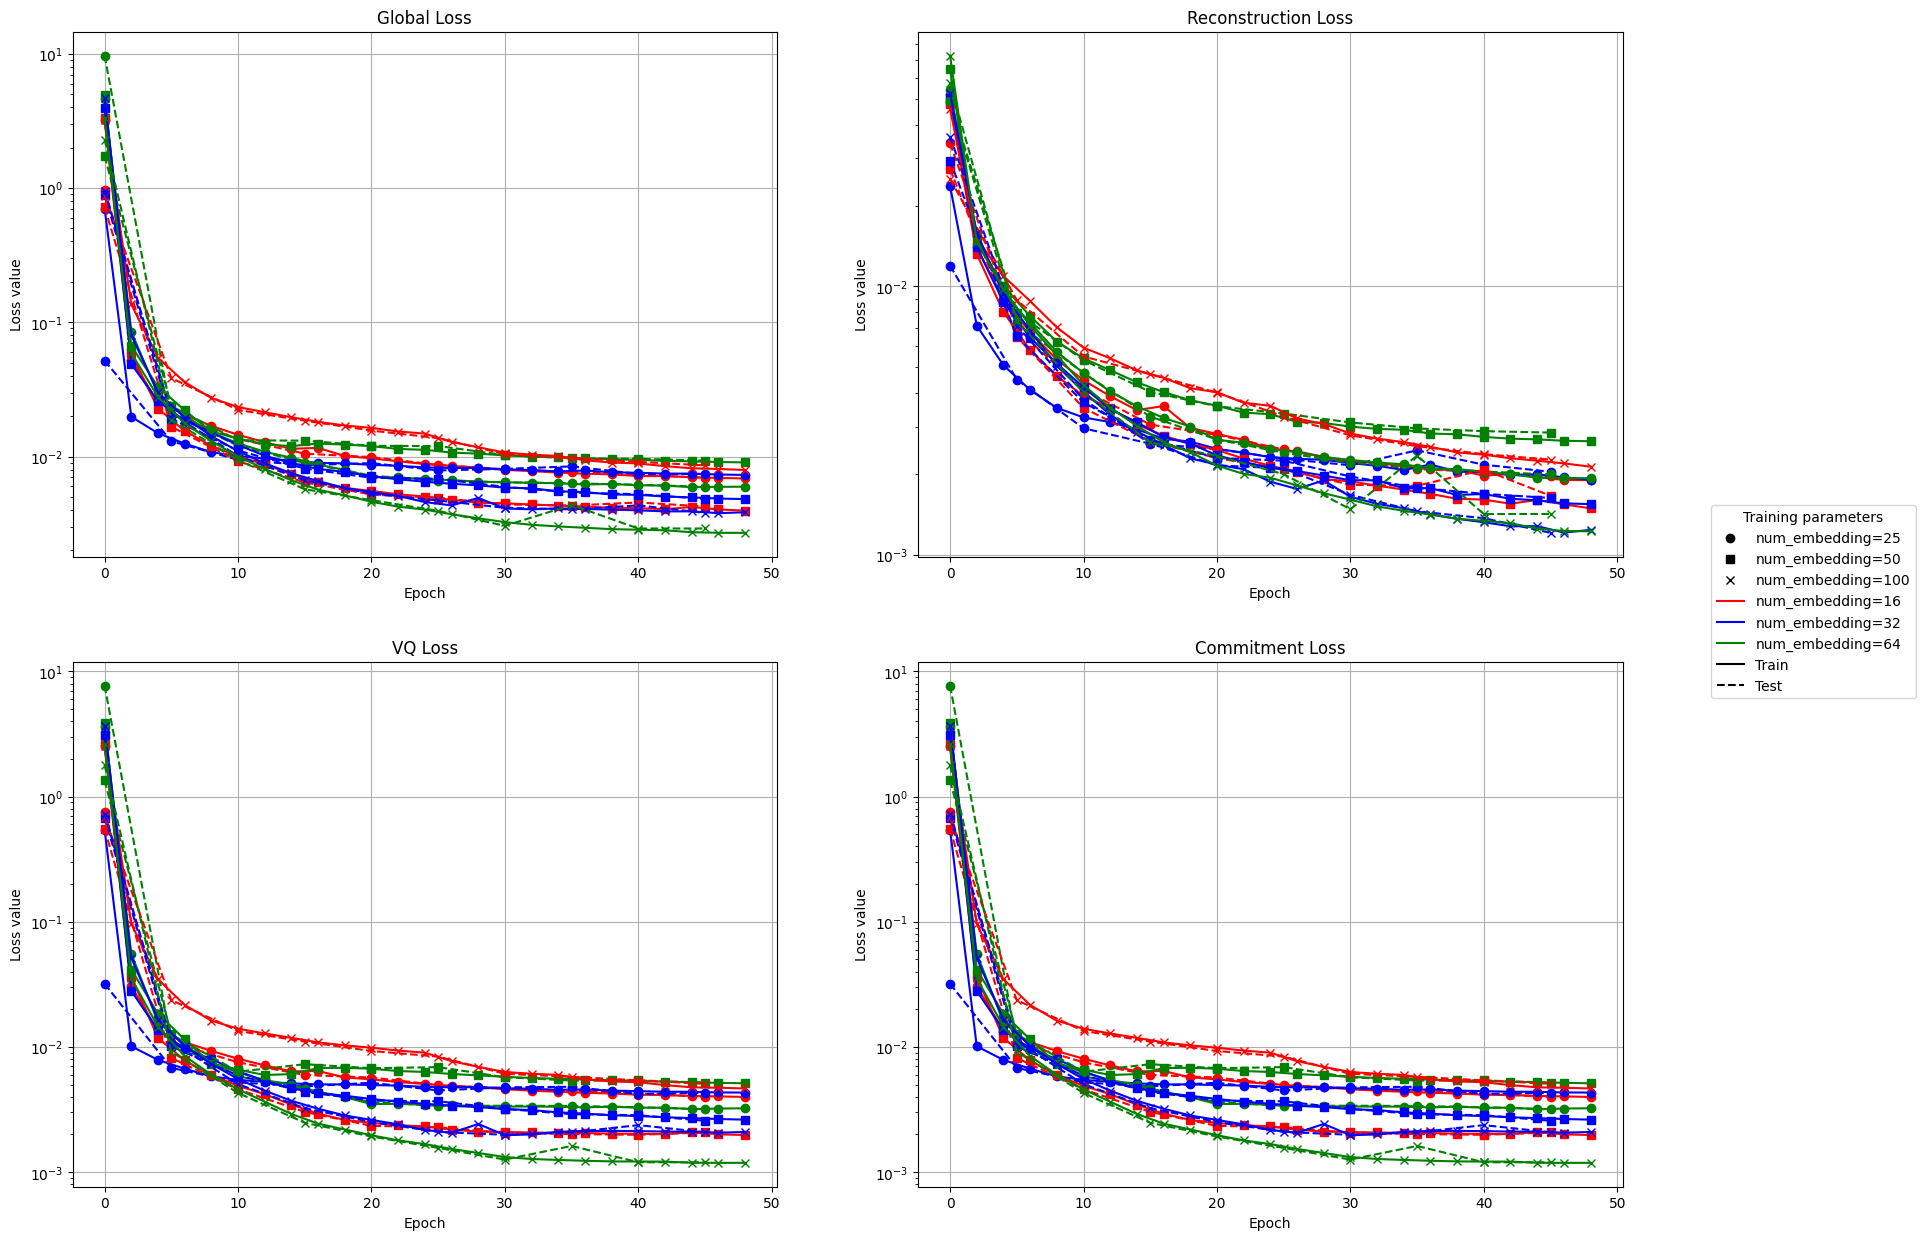

In [4]:
loaded_losses = load_losses(file_path=f'./checkpoints/losses_dicts')
plot_losses(loaded_losses)

comment on the losses

Using the loss, we can find the best set of parameters:

In [5]:
params = find_best_model_params(loaded_losses)
num_embedding = params[0]
embedding_dim = params[1]
checkpoint_path = f'./checkpoints/checkpoints_{num_embedding}_{embedding_dim}.pt'

Best parameters found in training, for the training set were:
         num_embedding=100
         embedding_dim=64
        with loss=2.6659e-03
Best parameters found in training, for the test set were:
         num_embedding=100
         embedding_dim=64
        with loss=2.6659e-03


## Define the model and load the checkpoint from training

In [6]:
model = VQ_VAE(num_embedding, embedding_dim).to(device)

In [7]:
model, epoch, loss = load_checkpoint(checkpoint_path, model, device)

/home/enzolouv/Documents/ENS PS 2024-2025/cours/computer_vision/opt_1/VQ_VAE/utils.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Using the model, we can compute, all the codebook indices,the reconstructed images and recontruction losses for each images from the dataset, and we sort by them by labels in a dictonarry.

In [8]:
# Define the dictonnaries
sorted_targets = {}
images_by_targets = {}
codebook_by_targets = {}
pred_images_by_targets = {}
errors_by_targets = {}

for target_id in tqdm(dict_label.keys(), desc='Targets'):

    # Sort the images by label
    sorted_targets[dict_label[target_id]] = np.where(test_dataset.targets == target_id)[0]

    # Get images associated to target
    images = []
    for idx in sorted_targets[dict_label[target_id]]:
        images.append(test_dataset[idx][0])

    images_by_targets[dict_label[target_id]] = torch.stack(images)

    # Compute the codebooks, losses and reconstructed images associated to target
    pred_images = []
    pred_codebook = []
    errors_by_targets[dict_label[target_id]] = []
    for image in tqdm(images_by_targets[dict_label[target_id]], leave=False):
        reconstructed, _, _, best_indices = model(image[None].to(device))
        with torch.no_grad():
            pred_images.append(reconstructed.detach().cpu())
            pred_codebook.append(best_indices.reshape(_.shape[2:]).detach().cpu())
            errors_by_targets[dict_label[target_id]].append(torch.nn.functional.mse_loss(pred_images[-1][0], image).item())
            
            del image
            del reconstructed
            del best_indices
            torch.cuda.empty_cache()
        
    codebook_by_targets[dict_label[target_id]] = torch.stack(pred_codebook)
    pred_images_by_targets[dict_label[target_id]] = torch.stack(pred_images)[:,0,...]

Targets: 100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


## **Latent Space Analysis**

## Statistical distribution
Let us first analyse the statistical distribution of the codebook indicesg grouped by target. 

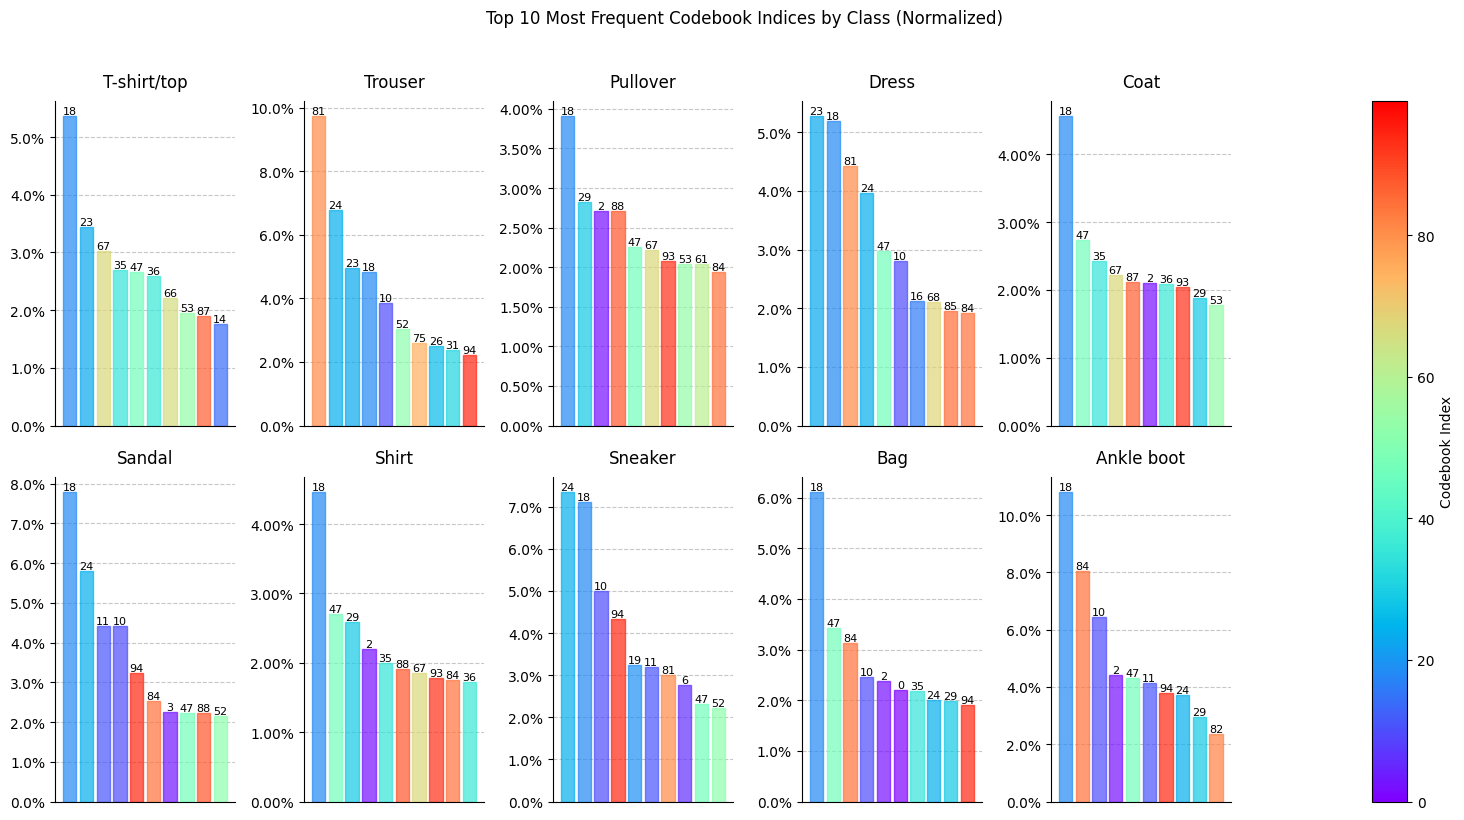

In [9]:
# Create color map
unique_codes = np.unique(np.concatenate([codebook_by_targets[k].reshape(-1).numpy() for k in codebook_by_targets.keys()]))
color_dict = dict(zip(unique_codes, plt.cm.rainbow(np.linspace(0, 1, len(unique_codes)))))

# Create figure with space for colorbar
figure = plt.figure(figsize=(15,8))  
gs = figure.add_gridspec(2, 6)  # 2 rows, 6 columns (5 for plots, 1 for colorbar)

# Create the main plots
for i, key in enumerate(codebook_by_targets.keys()):
    row = i // 5
    col = i % 5
    ax = figure.add_subplot(gs[row, col])  
    
    # Get counts and normalize them
    codebook_idx, count = np.unique(codebook_by_targets[key].reshape(-1).numpy(), return_counts=True)
    count = count / count.sum()
    
    # Sort and keep top 10
    sort_indices = np.argsort(-count)[:10]
    sorted_codebook_idx = codebook_idx[sort_indices]
    sorted_count = count[sort_indices]
    
    # Create bar plot
    bars = ax.bar(range(len(sorted_codebook_idx)), sorted_count)
    
    # Color each bar
    for idx, bar in enumerate(bars):
        bar.set_color(color_dict[sorted_codebook_idx[idx]])
        bar.set_alpha(0.7)
        
    # Add value labels
    for idx, rect in enumerate(bars):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                f'{sorted_codebook_idx[idx]}',
                ha='center', va='bottom', fontsize=8, rotation=0)
    
    # Set parameters of ax
    ax.set_xticks([])
    ax.set_title(f'{key}', pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Add colorbar in the last column, spanning both rows
cax = figure.add_subplot(gs[:, -1])  # Use last column, span both rows
norm = mcolors.Normalize(vmin=min(unique_codes), vmax=max(unique_codes))
sm = ScalarMappable(norm=norm, cmap=plt.cm.rainbow)
sm.set_array([])
cbar = ColorbarBase(cax, cmap=plt.cm.rainbow, norm=norm, label='Codebook Index')
cax.set_box_aspect(20)  # Make colorbar thinner

plt.suptitle('Top 10 Most Frequent Codebook Indices by Class (Normalized)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

comment <br>

## Vizualisation of codebook accross object class:
Now let us see the 2D heatmap of codebook usage patterns across different clothing categories:

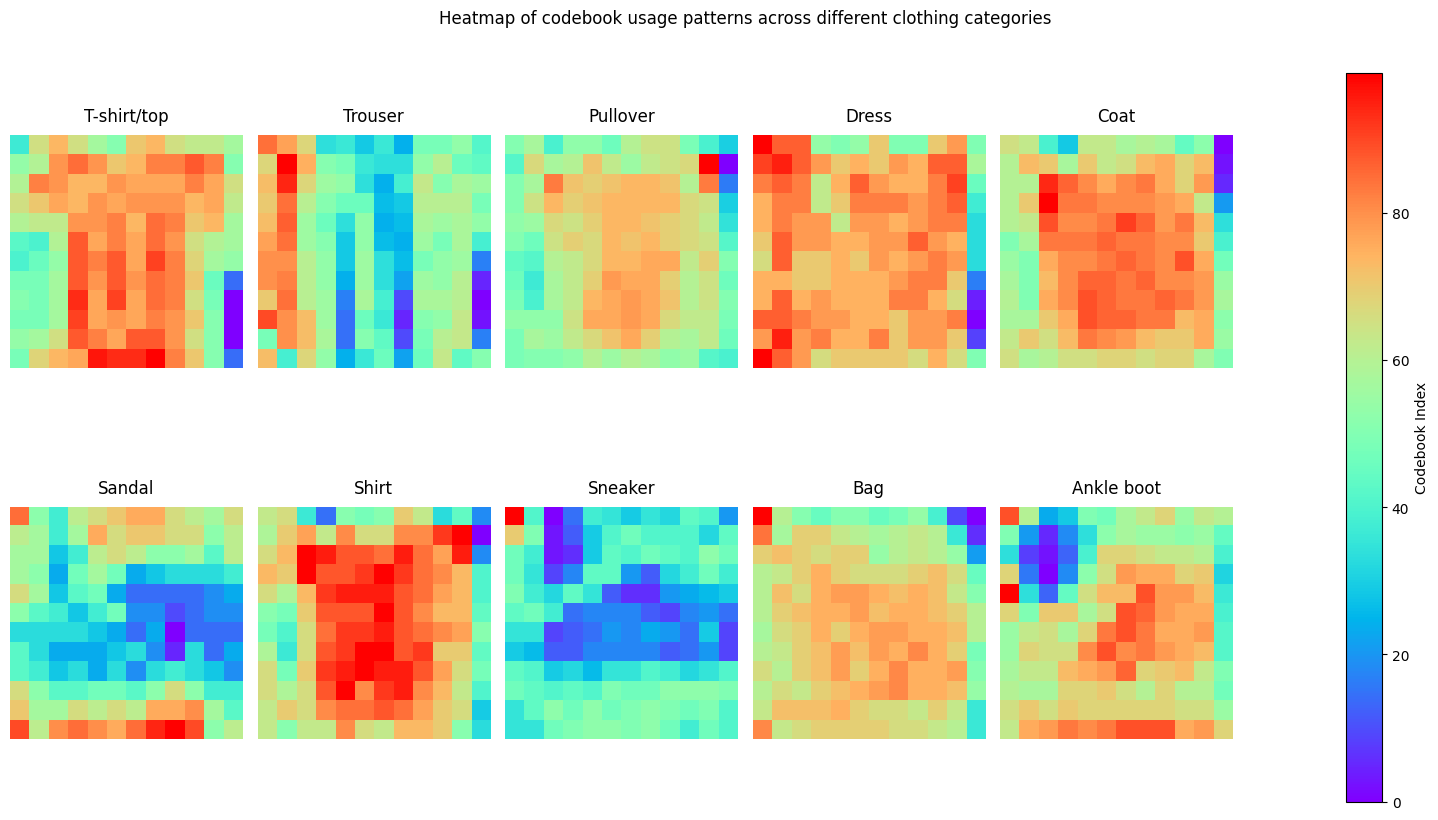

In [10]:

# Create figure with space for colorbar
figure = plt.figure(figsize=(15,8))  
gs = figure.add_gridspec(2, 6)  # 2 rows, 6 columns (5 for plots, 1 for colorbar)

for i, target in enumerate(codebook_by_targets.keys()):
    row = i // 5
    col = i % 5
    ax = figure.add_subplot(gs[row, col])  
    
    # Get codebooks and average them
    code_book_target_avg = (codebook_by_targets[target].sum(0)/len(codebook_by_targets[target])).ceil()
    
    # Display code_book_avg
    img = ax.imshow(code_book_target_avg, cmap=cm.rainbow)
    
    # Set parameters of ax
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{target}', pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Add colorbar in the last column, spanning both rows
cax = figure.add_subplot(gs[:, -1])  # Use last column, span both rows
norm = mcolors.Normalize(vmin=min(unique_codes), vmax=max(unique_codes))
sm = ScalarMappable(norm=norm, cmap=plt.cm.rainbow)
sm.set_array([])
cbar = ColorbarBase(cax, cmap=plt.cm.rainbow, norm=norm, label='Codebook Index')
cax.set_box_aspect(20)  # Make colorbar thinner

plt.suptitle('Heatmap of codebook usage patterns across different clothing categories', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

comment

## Learned codebook

Using dimensionality reduction, we can visualize the learned codebook vectors. For each point, we find the dominant class. We try to identify clusters of same type.

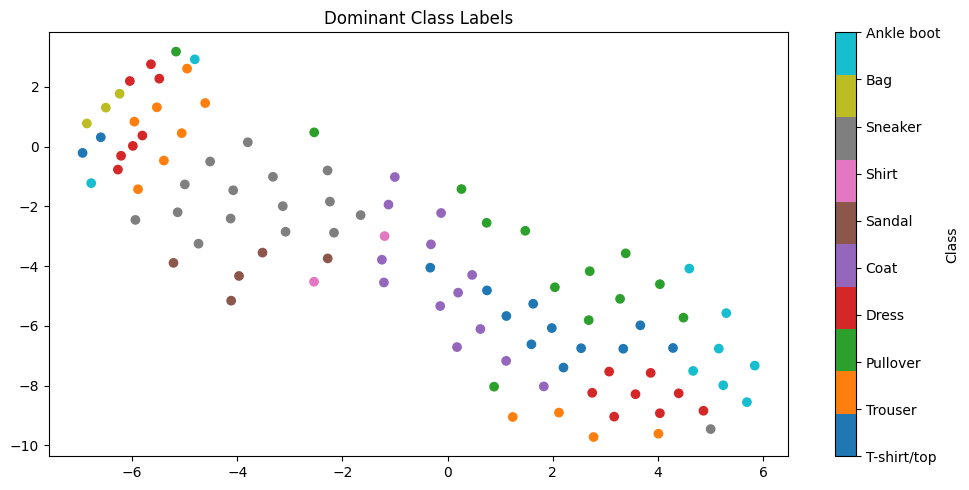

In [11]:


# Get codebook vectors and their usage per class
codebook_vectors = model.embedding_vectors.weight.detach().cpu().numpy()

# Apply t-SNE from scikit-learn
tsne = TSNE(n_components=2, random_state=42)
codebook_tsne = tsne.fit_transform(codebook_vectors)

# Get the most common class for each codebook vector
codebook_labels = np.zeros(len(codebook_vectors))
codebook_class_counts = np.zeros((len(codebook_vectors), 10))  # 10 classes

for class_idx, class_name in enumerate(codebook_by_targets.keys()):
    class_codes = codebook_by_targets[class_name].reshape(-1).numpy()
    for code in class_codes:
        codebook_class_counts[code, class_idx] += 1

dominant_class = np.argmax(codebook_class_counts, axis=1)


# Plot 2: Dominant class labels
figure = plt.figure(figsize=(10, 5))
ax = figure.add_subplot(111)
scatter = ax.scatter(codebook_tsne[:, 0], codebook_tsne[:, 1], 
                     c=dominant_class,
                     cmap='tab10',
                     alpha=1)
ax.set_title('Dominant Class Labels')
cb = plt.colorbar(scatter, label='Class')
cb.set_ticks(np.arange(10))
cb.set_ticklabels([dict_label[i] for i in range(10)])
figure.tight_layout()
plt.show()

comment 

## **Reconstruction Quality Analysis**

## Examples
First let us observer some examples from each class of orginal and reconstructed images.

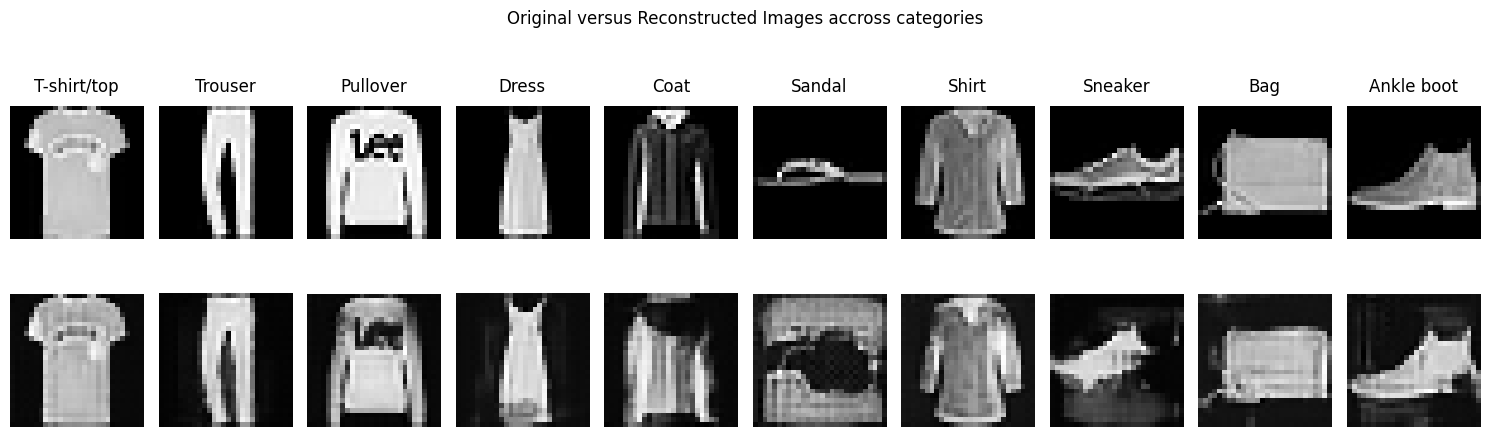

In [12]:
# Create figure
figure = plt.figure(figsize=(15,5))  
gs = figure.add_gridspec(2, 10)  # 2 rows, 10 columns (1 row for original images, 1 for row for reconstructed images)
idx = 0

for i, target in enumerate(codebook_by_targets.keys()):
    col = i  # Determine column 
    ax = figure.add_subplot(gs[0, col])  
    
    # Display image  
    img = ax.imshow(images_by_targets[target][idx,0], cmap=cm.gray)
    
    # Set axis parameters
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.set_title(f'{target}', pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    col = i  # Determine column 
    ax = figure.add_subplot(gs[1, col])  
    
    # Display corresponding reconstructed 
    img = ax.imshow(pred_images_by_targets[target][idx,0], cmap=cm.gray)

    # Set axis parameters
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


plt.suptitle('Original versus Reconstructed Images accross categories', fontsize=12)
plt.tight_layout()
plt.show()

comment

## Reconstruction error distribution

Using the loss computed before, we can have the violin plot, as well the best reconstruction and the worst

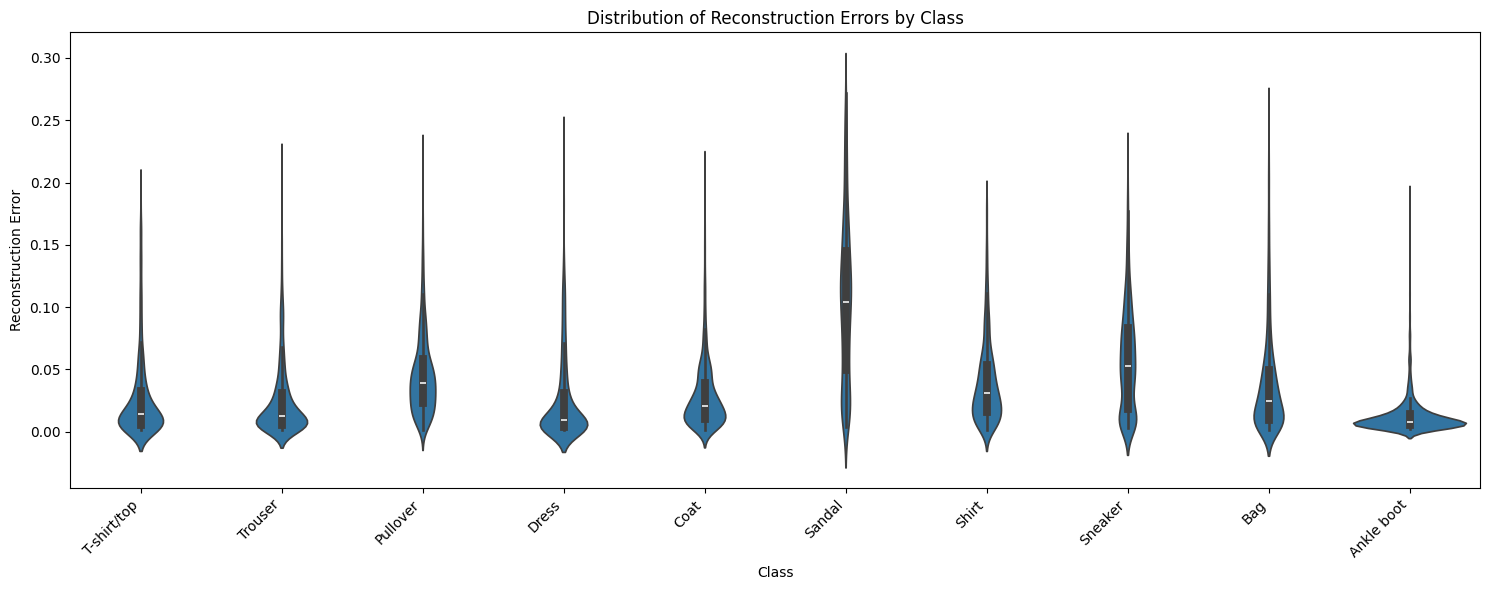

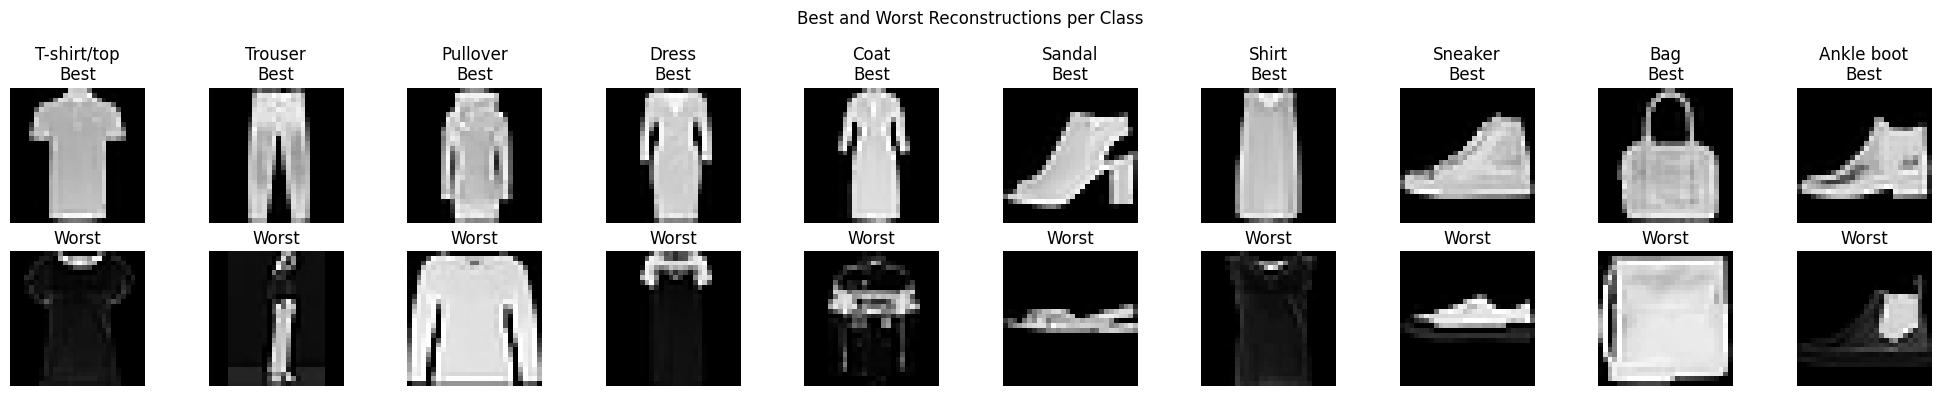


Summary Statistics:
--------------------------------------------------
               mean     std     min     max
Class                                      
Ankle boot   0.0123  0.0140  0.0018  0.1903
Bag          0.0378  0.0406  0.0011  0.2556
Coat         0.0290  0.0273  0.0011  0.2115
Dress        0.0249  0.0342  0.0009  0.2356
Pullover     0.0457  0.0325  0.0016  0.2220
Sandal       0.1031  0.0639  0.0034  0.2718
Shirt        0.0398  0.0335  0.0013  0.1846
Sneaker      0.0572  0.0421  0.0025  0.2188
T-shirt/top  0.0264  0.0334  0.0013  0.1937
Trouser      0.0241  0.0285  0.0014  0.2168


In [13]:
# Convert to DataFrame for seaborn
error_data = []
for class_idx, errors in errors_by_targets.items():
    for error in errors:
        error_data.append({
            'Class': class_idx,
            'Reconstruction Error': error
        })
error_df = pd.DataFrame(error_data)

# Create violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(data=error_df, x='Class', y='Reconstruction Error')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Reconstruction Errors by Class')
plt.tight_layout()
plt.show()


# Show example reconstructions
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
plt.suptitle('Best and Worst Reconstructions per Class')

for class_idx in range(10):
    # Get best and worst indices for this class
    errors = np.array(errors_by_targets[dict_label[class_idx]])
    best_idx = np.argmin(errors)
    worst_idx = np.argmax(errors)
    
    # Get original and reconstructed images
    original_best = images_by_targets[dict_label[class_idx]][best_idx]
    original_worst = images_by_targets[dict_label[class_idx]][worst_idx]
    
    with torch.no_grad():
        reconstructed_best, _, _, _ = model(original_best[None].to(device))
        reconstructed_worst, _, _, _ = model(original_worst[None].to(device))
    
    # Plot best case
    axes[0, class_idx].imshow(original_best.cpu().squeeze(), cmap='gray')
    axes[0, class_idx].axis('off')
    axes[0, class_idx].set_title(f'{dict_label[class_idx]}\nBest')
    
    # Plot worst case
    axes[1, class_idx].imshow(original_worst.cpu().squeeze(), cmap='gray')
    axes[1, class_idx].axis('off')
    axes[1, class_idx].set_title(f'Worst')

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
print("\nSummary Statistics:")
print("-" * 50)
summary_stats = error_df.groupby('Class')['Reconstruction Error'].agg(['mean', 'std', 'min', 'max'])
print(summary_stats.round(4))



comment
## **Latent space interpolation**

In [14]:
best_trouser = np.array(errors_by_targets['Trouser']).argmin()
best_boot = np.array(errors_by_targets['Ankle boot']).argmin()
image_0 = images_by_targets['Trouser'][best_trouser]
image_1 = images_by_targets['Ankle boot'][best_boot]

with torch.no_grad():
    _, _, zq_0, code0 = model(image_0[None].to(device))
    _, _, zq_1, code1  = model(image_1[None].to(device))

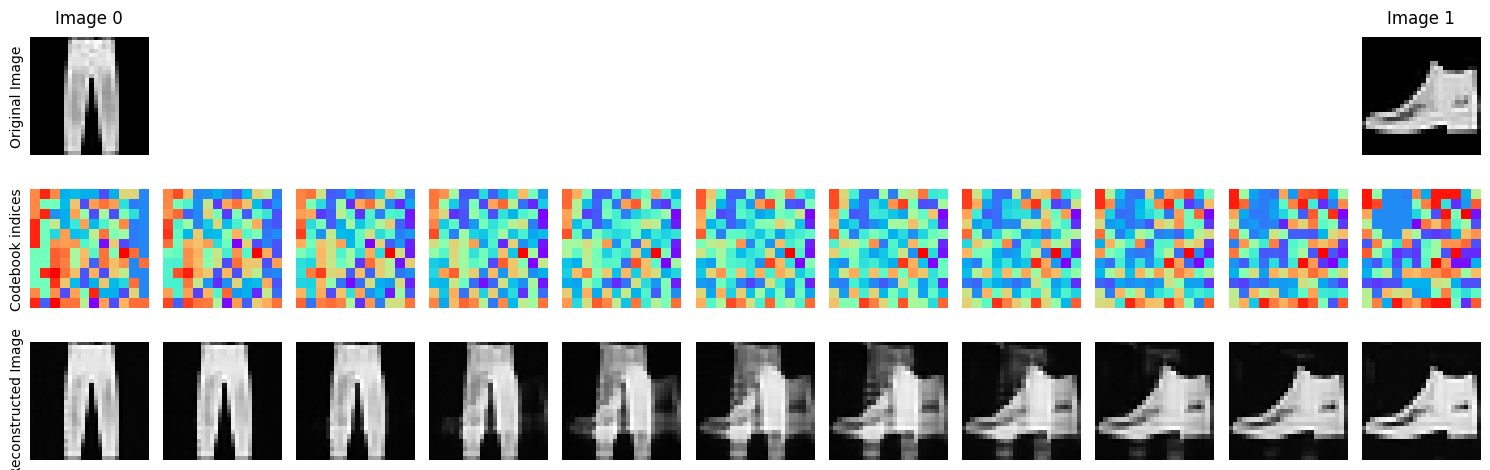

In [15]:
zqs = []
codes = []
nb_interp = 10

for i in range(nb_interp+1):
    zqs.append((zq_0*(nb_interp-i) + zq_1*i)/nb_interp)
    codes.append((code0*(nb_interp-i) + code1*i)/nb_interp)
zqs = torch.stack(zqs)
codes = torch.stack(codes)

interp_recon = model.decoder(zqs[:,0,...].to(device)).detach().cpu()

figure = plt.figure(figsize=(15,5))  # Adjusted height for 2 rows
gs = figure.add_gridspec(3, nb_interp+1)  # 2 rows, 10 columns (1 row for original images, 1 for row for reconstructed images)

ax = figure.add_subplot(gs[0,0])
img = ax.imshow(image_0[0], cmap=cm.gray)
ax.set_xticks([])
ax.set_yticks([])    
ax.set_title('Image 0', pad=10)
ax.set_ylabel('Original Image')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax = figure.add_subplot(gs[0,-1])
img = ax.imshow(image_1[0], cmap=cm.gray)
ax.set_xticks([])
ax.set_yticks([])    
ax.set_title('Image 1', pad=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i, code in enumerate(codes):
    ax = figure.add_subplot(gs[1,i])
    img = ax.imshow(code.reshape(zqs[0].shape[2:]).detach().cpu(), cmap=cm.rainbow)
    ax.set_xticks([])
    ax.set_yticks([]) 
    if i==0:   
        ax.set_ylabel('Codebook indices')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

for i, rec_img in enumerate(interp_recon):
    ax = figure.add_subplot(gs[2,i])
    img = ax.imshow(rec_img[0], cmap=cm.gray)
    ax.set_xticks([])
    ax.set_yticks([])     
    if i==0:   
        ax.set_ylabel('Reconstructed Image')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()


comment